# Estimating how active actors will be

In this post, we will try to modelize and forecast how many movies we can expect actors to appear in in the future based on their past activity. This is a problem that bears many similarities with marketing topics such as customer analysis, and can be viewed as a Customer Lifetime Value problem. The approach we will present here differs from time series in that we do not really  associate movies with time units with attention, but rather look at aggregate numbers of movies during time ranges to fit probabilistic models.

For the purpose of this analysis, we will look at actors activity between 1950 and 1959 and try to estimate how many movies we can expect them to make in the next decade, from 1960 to 1969. In more statistical terms, we define 1950-1959 as our train period and 1960-1969 as our test period.

One main prerequisite of Customer Lifetime Value analysis is that by the beginning of the train period, all actors should be active. We should also ensure that by the end of the train period, all actors could still potentially be active. Hence, we will define active actors as actors who made at least one movie between 1945 and 1949 and that did not pass away before 1959. This will ensure that we only select actors that had already started their career by 1950 and that had the potential to continue their career after 1959. 

## 1. Load Data

First, let us install all the packages required for this project. We will mainly be using the package <a href ='https://lifetimes.readthedocs.io/en/latest/index.html'>lifetimes</a>, which has most of the underlying maths already implemented.

In [0]:
%%capture
! pip install lifetimes

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifetimes import ParetoNBDFitter
from lifetimes.plotting import plot_frequency_recency_matrix, plot_probability_alive_matrix, plot_history_alive
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import gamma
%matplotlib inline

The data we will be using is from IMDB, the code below does loads, unzips and reads the three tables we will need here:

- A cast table that maps movie IDs to actor IDs
- A title table that maps movie IDs to movie information
- A name table that maps actor IDs to actor information

In [0]:
%%capture
! wget "https://datasets.imdbws.com/title.principals.tsv.gz"
! wget "https://datasets.imdbws.com/title.basics.tsv.gz"
! wget "https://datasets.imdbws.com/name.basics.tsv.gz"

! gunzip title.principals.tsv.gz
! gunzip title.basics.tsv.gz
! gunzip name.basics.tsv.gz

In [0]:
cast = pd.read_csv('title.principals.tsv', sep='\t', na_values = "\\N", keep_default_na = False, 
                   usecols = ['tconst','ordering','nconst','category','job'],
                   dtype = {'tconst': str, 'ordering': 'Int64', 'nconst': str, 'category': str, 'job': str})
titles = pd.read_csv('title.basics.tsv', sep='\t', na_values = "\\N", keep_default_na = False,
                     usecols = ['tconst','primaryTitle','startYear','titleType'],
                    dtype = {'tconst': str, 'primaryTitle': str, 'startYear': 'Int64','titleType':str})
names = pd.read_csv('name.basics.tsv', sep='\t', na_values = "\\N", keep_default_na = False,
                    usecols = ['nconst','primaryName','birthYear','deathYear'],
                   dtype = {'nconst': str, 'primaryName': str, 'birthYear': 'Int64', 'deathYear': 'Int64'})

To get a sense of what these three tables look like, here are some snippets:

In [7]:
cast.head()

,tconst,ordering,nconst,category,job
0,tt0000001,1,nm1588970,self,NaN
1,tt0000001,2,nm0005690,director,NaN
2,tt0000001,3,nm0374658,cinematographer,director of photography
3,tt0000002,1,nm0721526,director,NaN
4,tt0000002,2,nm1335271,composer,NaN


In [8]:
movie_titles = titles[titles.titleType == 'movie']
movie_titles.head()

,tconst,titleType,primaryTitle,startYear
8,tt0000009,movie,Miss Jerry,1894
145,tt0000147,movie,The Corbett-Fitzsimmons Fight,1897
332,tt0000335,movie,Soldiers of the Cross,1900
499,tt0000502,movie,Bohemios,1905
571,tt0000574,movie,The Story of the Kelly Gang,1906


In [9]:
names["alive"] = names.deathYear.isnull()
names.head()

,nconst,primaryName,birthYear,deathYear,alive
0,nm0000001,Fred Astaire,1899,1987,False
1,nm0000002,Lauren Bacall,1924,2014,False
2,nm0000003,Brigitte Bardot,1934,NaN,True
3,nm0000004,John Belushi,1949,1982,False
4,nm0000005,Ingmar Bergman,1918,2007,False


## 2. Data Preparation

### Getting the transactional data for active actors

The first thing we need to do is to keep only the actors that are active according to these two criteria (already specified above):

 - they need to have been active between 1945 and 1949, before the train period starts
 - they need to have been alive in 1959, when the train period ends

In [0]:
startYear = 1950
endYear = 1960

In [0]:
# Filtering out actors that died before the end of the train period
classic_names = names[(names.birthYear<=startYear-10) & ((names.deathYear>=endYear) | (names.alive == True))]

# Merging all three data tables
classic_cast_actors = pd.merge(classic_names, cast, on = 'nconst')
movie_actors = pd.merge(classic_cast_actors, movie_titles, on = 'tconst')
movie_list = movie_actors[['primaryName','birthYear','deathYear','category','primaryTitle','startYear']]
movie_list = movie_list[movie_list.category.isin(['actor','actress'])]

# Filtering out actors that we not active in the 5 years prior to the start of the train period
active_actors = movie_list[movie_list.startYear > startYear - 5].groupby("primaryName").agg({"startYear":'min'}).reset_index()
active_actors_list = active_actors[active_actors.startYear < startYear]
actors_list = active_actors_list["primaryName"]
movie_list = movie_list[movie_list.primaryName.isin(actors_list)]

# Splitting the train and test period
movie_list_observed = movie_list[movie_list.startYear.isin(range(startYear,endYear))]
movie_list_unobserved = movie_list[movie_list.startYear.isin(range(endYear,endYear+10))]

Eventually, we get a list of all the movies made by active actors during the train period. In CLV terms, this data is called the "transactional data", meaning there is one record by observation over time for each party. We have these tables for both the train period (observed) and test period (unobserved).

In [12]:
movie_list_observed.head()

,primaryName,birthYear,deathYear,category,primaryTitle,startYear
162,Fred Astaire,1899,1987,actor,Let's Dance,1950
163,Betty Hutton,1921,2007,actress,Let's Dance,1950
167,Ruth Warrick,1916,2005,actress,Let's Dance,1950
169,Fred Astaire,1899,1987,actor,Three Little Words,1950
170,Arlene Dahl,1925,NaN,actress,Three Little Words,1950


### Getting the summary data for active actors

Transactional data is a natural way of formatting the data, as it allows to quickly access all the movies made by an actor for each year. However, most of this data is actually redundant for the methodologies we are going to be using, which are not time series-based. 

Most of the analysis below will rely on summary data instead, which is simply an aggregated count of the movies by actor during the train period.

In [0]:
movie_counts = movie_list_observed.groupby(['primaryName','startYear']).agg({'primaryTitle': 'count'}).reset_index().rename(columns = {'primaryTitle':'numberMovies'})
movie_counts_validation = movie_list_unobserved.groupby(['primaryName','startYear']).agg({'primaryTitle': 'count'}).reset_index().rename(columns = {'primaryTitle':'numberMovies'})

In [14]:
movie_counts.head()

,primaryName,startYear,numberMovies
0,A.E. Matthews,1951,1
1,A.E. Matthews,1952,3
2,A.E. Matthews,1954,1
3,A.E. Matthews,1956,1
4,Abbas Fares,1951,3


In [15]:
movie_counts.groupby('primaryName').agg({'numberMovies':'sum'}).head()

,numberMovies
primaryName,
A.E. Matthews,6
Abbas Fares,8
Abdel Aziz Mahmoud,8
Abdel Fatah Al Kasri,13
Abdulsalam El-Nabulsi,37


## 3. Data Exploration

In [16]:
print("There are %i active actors between %i and %i in our data." %(len(actors_list),startYear, endYear-1))

There are 5668 active actors between 1950 and 1959 in our data.


Given there are no less than 5662 active actors in our data in the 50's, we might just as well pick a few of them to get a sense of how the data looks and then later how our estimation methodology works for them.

In [73]:
actors = ["Bette Davis", "Cary Grant", "Ingrid Bergman", "James Stewart", "Elizabeth Taylor", "Henry Fonda",
         "Robert Mitchum", "Barbara Stanwyck"]

names_actors = classic_names[classic_names.primaryName.isin(actors)].head(len(actors))
names_actors

,nconst,primaryName,birthYear,deathYear,alive
5,nm0000006,Ingrid Bergman,1915,1982,False
11,nm0000012,Bette Davis,1908,1989,False
19,nm0000020,Henry Fonda,1905,1982,False
25,nm0000026,Cary Grant,1904,1986,False
52,nm0000053,Robert Mitchum,1917,1997,False
70,nm0000071,James Stewart,1908,1997,False
71,nm0000072,Elizabeth Taylor,1932,2011,False
1764,nm0001766,Barbara Stanwyck,1907,1990,False


An important thing to note is that the year of death is not data that is available to us in this problem. Indeed, the train period stops in 1959, meaning that all we observe is who is still alive by that time. We can already see why this would be an issue: from this table, two actors (Gary Cooper and Clark Gable) died in the early 60's, which "unexpectedly" reduced the number of movies they did in this decade. 

Let us have a closer look at the activity of these major stars of the 50's by plotting the number of movies they made by year.

In [0]:
def plot_history_actor(ax, actor_name, max_value):
  actor_history = movie_counts[movie_counts.primaryName == actor_name]
  ax.bar(actor_history.startYear, actor_history.numberMovies, color = 'firebrick')
  ax.set_xticks([i for i in range(1950,1960)])
  ax.set_yticks(np.linspace(0,max_value,max_value+1))
  ax.set_title(actor_name)
  ax.set_facecolor("linen")
  ax.grid(color = 'white', linewidth = 1.5)
  ax.set_axisbelow(True)

def plot_history_actors(actors):
  n = len(actors)
  k = round(n/3+0.5)
  max_value = movie_counts[movie_counts.primaryName.isin(actors)].numberMovies.max()
  fig, axes = plt.subplots(k,3, figsize = (15,2*k))
  for ax, actor_name in zip(axes.ravel(), actors):
    plot_history_actor(ax, actor_name, max_value)
  for i in range(n,k*3):
    fig.delaxes(axes.ravel()[i])
  fig.suptitle("Number of movies made each year", y = 1.1, fontsize = 20)
  fig.tight_layout()

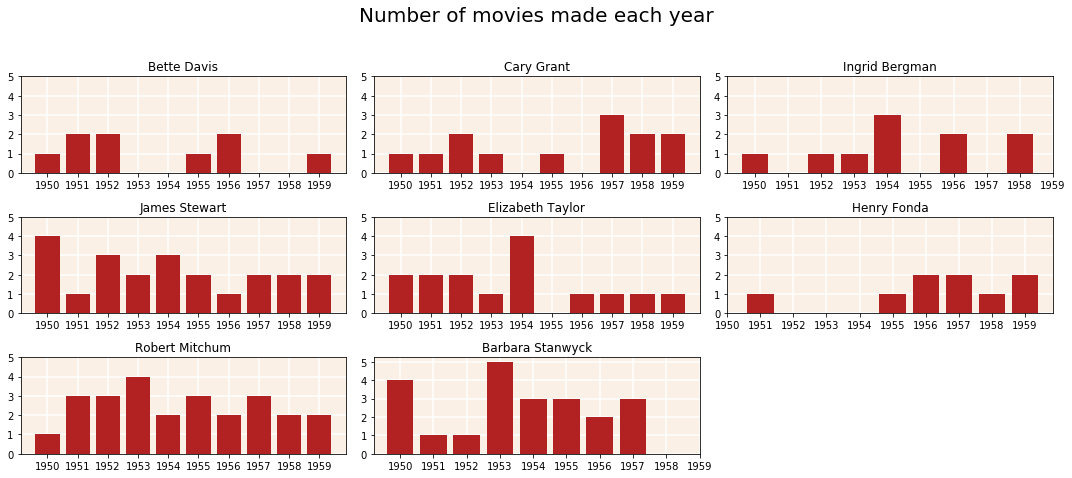

In [74]:
plot_history_actors(actors)

## 4. Fitting a Poisson process

### Model setting and estimation

Our first attempt will be to fit a Poisson process to each actor's activity. From a mathematical point of view, this means we assume $N_{a,t}$, the number of movies made by actor $a$ until time $t$ follows a Poisson distribution with parameter $\lambda_a \times t$. In other words,

$$P[N_{a,t} = n] = \frac{(\lambda_a t)^n}{n!} e^{-\lambda_a t}$$

The implications of this model are actually very simplistic. This means that on average, an actor $a$ will make $\lambda_a$ movies a year. It also means that this activity rate $\lambda_a$ is constant over time, and that the the expected number of movies in $t$ years is simply $\lambda_a \times t$.

As a result, it is very straightforward to estimate $\lambda_a$ for each actor using the Maximum Likelihood Estimator with $\widehat{\lambda_a} = \frac{N_{a,T}}{T}$.

In [75]:
lambda_actors = movie_counts.groupby("primaryName").agg({"numberMovies" : "sum"}).reset_index()
lambda_actors["lambda"] = lambda_actors.numberMovies/(endYear - startYear)
lambda_actors = lambda_actors.merge(actors_list, on = "primaryName", how = "right").fillna(0)
lambda_actors["numberMovies"] = lambda_actors.numberMovies.astype(int)

lambda_actors[lambda_actors.primaryName.isin(actors)].head()

,primaryName,numberMovies,lambda
350,Barbara Stanwyck,22,2.2
397,Bette Davis,9,0.9
549,Cary Grant,13,1.3
922,Elizabeth Taylor,15,1.5
1462,Henry Fonda,9,0.9


### Model interpretation

The table above gives the estimated values of $\lambda_a$ for each actor. This gives us the straightforward result: if an actor played in x movies during the train period, we can expect him or she to also play in x movies during the test period...

"All the trouble for... this? I could have guessed this on my own without a complicated Poisson process..." Sure! 

However, the interesting part of the Poisson process is that it provides us with a probability distribution of the number of movies an actor will play in. In other words, we can assess the probability for each actor to play in $n$ movies, which is a much richer information than just the expected number of movies in a time period.

The following plots show the probability distribution for each actor along with the expected value (the dashed black line).

In [0]:
def probability(lambda_param, t, k):
  return np.exp(-lambda_param*t)*(lambda_param*t)**k/np.math.factorial(k)

def plot_probability_actor(ax, actor_name, t):
  lambda_param = lambda_actors[lambda_actors.primaryName == actor_name]["lambda"].iloc[0]
  k_list = np.linspace(0,40,41)
  probability_list = np.array([probability(lambda_param, t, k) for k in k_list])
  ax.plot(k_list, probability_list, color = 'firebrick')
  ax.fill_between(k_list, probability_list,  color = 'firebrick', alpha = 0.5)
  ax.axvline(x=lambda_param*t, color = 'k', linestyle = '--')
  ax.set_title(actor_name)
  ax.set_facecolor("linen")
  ax.grid(color = 'white', linewidth = 1.5)
  ax.set_axisbelow(True)

def plot_probability_actors(actors, t):
  n = len(actors)
  k = round(n/3+0.5)
  fig, axes = plt.subplots(k,3, figsize = (15,2*k))
  for ax, actor_name in zip(axes.ravel(), actors):
    plot_probability_actor(ax, actor_name, t)
  for i in range(n,k*3):
    fig.delaxes(axes.ravel()[i])
  fig.suptitle("Fitted probability distribution for t = " + str(t)+ " years", y = 1.1, fontsize = 20)
  fig.tight_layout()

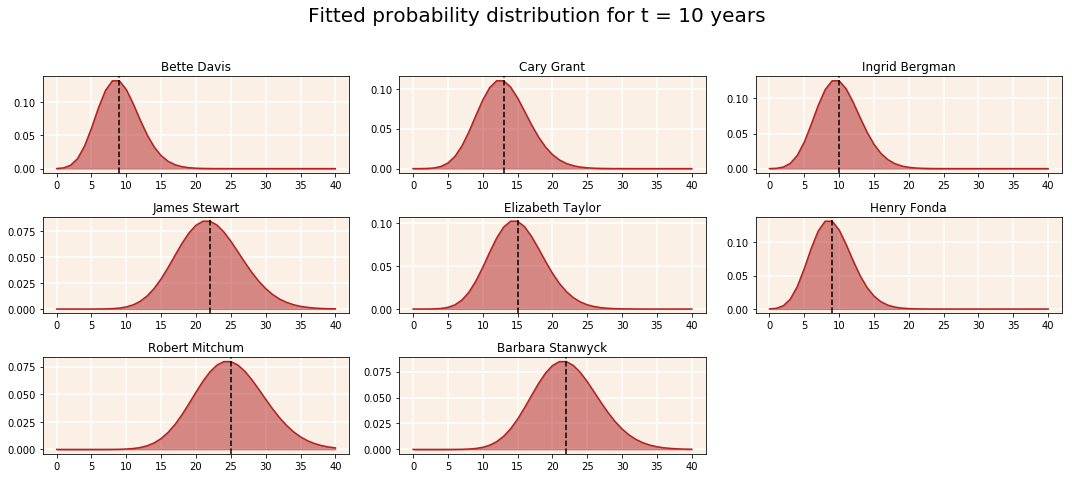

In [76]:
plot_probability_actors(actors, 10)

More intuitively, this probability distribution can also be viewed as a cumulative distribution function:

In [0]:
def cdf(lambda_param, t, n):
  cdf = 0
  for i in range(n):
    cdf += probability(lambda_param, t, i)
  return cdf

In [0]:
def plot_cdf_actor(ax, actor_name, t):
  lambda_param = lambda_actors[lambda_actors.primaryName == actor_name]["lambda"].iloc[0]
  n_list = np.linspace(0,40,41, dtype = int)
  probability_list = np.array([1-cdf(lambda_param, t, n) for n in n_list])
  ax.bar(n_list, probability_list, color = 'firebrick')
  ax.set_yticks(np.linspace(0,1,5))
  ax.set_title(actor_name)
  ax.set_facecolor("linen")
  ax.grid(color = 'white', linewidth = 1.5)
  ax.set_axisbelow(True)

def plot_cdf_actors(actors, t):
  n = len(actors)
  k = round(n/3+0.5)
  fig, axes = plt.subplots(k,3, figsize = (15,2*k))
  for ax, actor_name in zip(axes.ravel(), actors):
    plot_cdf_actor(ax, actor_name, t)
  for i in range(n,k*3):
    fig.delaxes(axes.ravel()[i])
  fig.suptitle("Probability of appearing in more than n movies in t = "+ str(t) +" years", y = 1.1, fontsize = 20)
  fig.tight_layout()

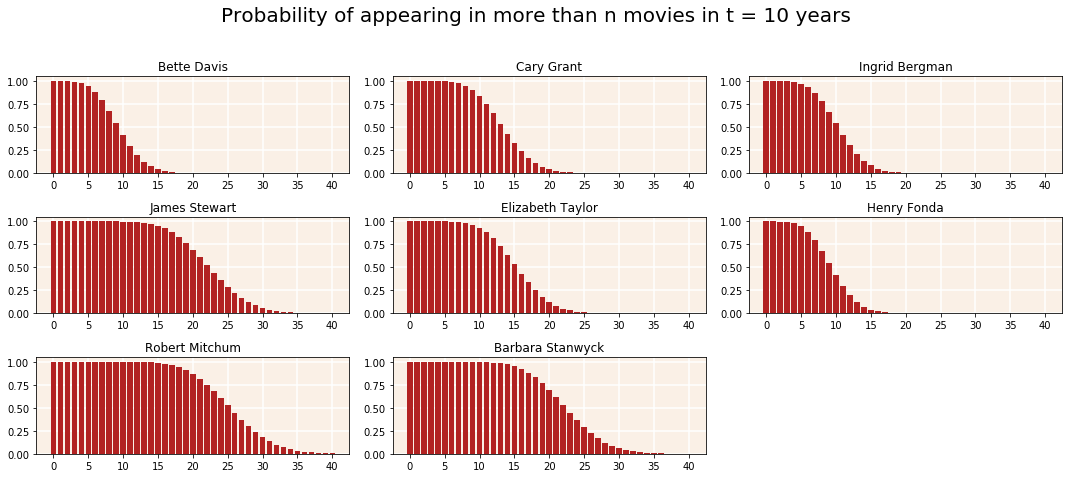

In [77]:
plot_cdf_actors(actors, 10)

This plot tells use for instance that the probability to appear in more than 10 movies between 1960 and 1969 is roughly 40% for Bette Davis, 15% for Katharine Hepburn and 95% for James Stewart.

Another benefit of the Poisson distribution is that it also brings interesting results for the waiting time between two movies. Indeed, with our previous notation, the waiting time for an actor $a$ follows an exponential distribution of parameter $\lambda_a$. This tells of for instance that the average waiting time between two movies for actor $a$ is $1/\lambda_a$.

In [0]:
def waiting_time(lambda_param, t):
  return np.exp(-lambda_param*(t-1)) - np.exp(-lambda_param*t)

In [0]:
def plot_waiting_time_actor(ax, actor_name):
  lambda_param = lambda_actors[lambda_actors.primaryName == actor_name]["lambda"].iloc[0]
  t_list = np.linspace(1,5,5, dtype = int)
  waiting_time_list = np.array([waiting_time(lambda_param, t) for t in t_list])
  x_axis = [str(t-1) + "-" + str(t) + " y" for t in t_list]
  ax.bar(x_axis, waiting_time_list, color = 'firebrick')
  ax.set_yticks(np.linspace(0,1,5))
  ax.set_title(actor_name)
  ax.set_facecolor("linen")
  ax.grid(axis = 'y', color = 'white', linewidth = 1.5)
  ax.set_axisbelow(True)

def plot_waiting_time_actors(actors):
  n = len(actors)
  k = round(n/3+0.5)
  fig, axes = plt.subplots(k,3, figsize = (15,2*k))
  for ax, actor_name in zip(axes.ravel(), actors):
    plot_waiting_time_actor(ax, actor_name)
  for i in range(n,k*3):
    fig.delaxes(axes.ravel()[i])
  fig.suptitle("Probability distribution of waiting time between two movies in years", y = 1.1, fontsize = 20)
  fig.tight_layout()

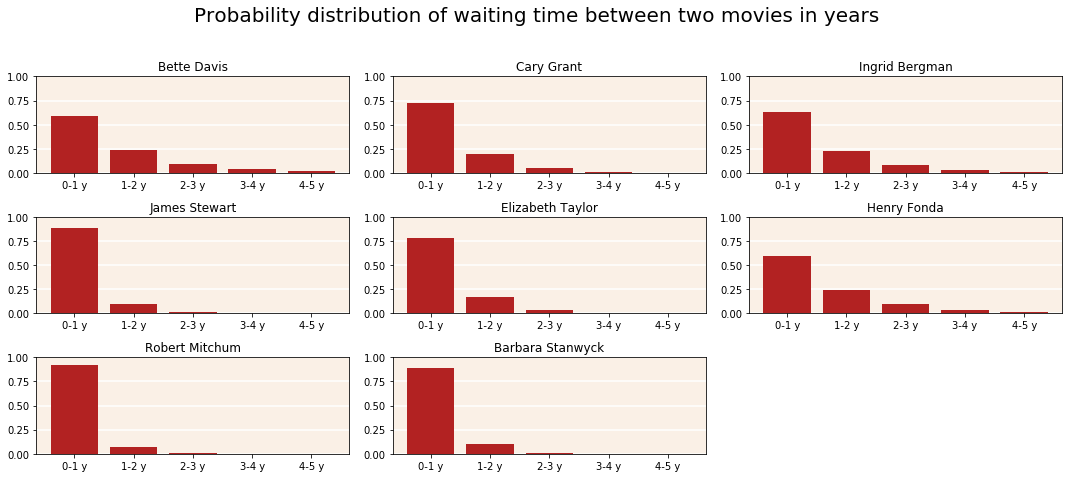

In [78]:
plot_waiting_time_actors(actors)

From the plot above, we can read that there is a 85% probability that James Stewart waits less than a year to make another movie, whereas it is only 50% for Katharine Hepburn.

As we can see from this section, despite the model's simplicity, it has a lot of informative and interpretational power, which is why it is such a convenient tool for analytics. Let us now move on to actually evaluating it.

### Model evaluation

By definition, the Poisson process is unbiased. The expected number of movies for 10 years will always be equal to the number of movies in the train period. 

However, the main part we want to assess in this model is how well it is calibrated. If the model is well calibrated, then for any $k = 0, 1, ...$, we should have $S_{k,t} = \sum_a P[N_{a,t} = k]$ where $S_{k,t}$ is the number of movies made by all active actors after $t$. 

In less mathematical terms, it means that if the model claims that for a given actor, there are x% chances to participate in k movies, it really happens with x% probability. The difficulty is that it cannot be assessed an individual level, only at an aggregate level. If most active actors have a high probability to make 0 movies in $t$ years, then we should expect a large number of actors to indeed make 0 movies in $t$ years. 

Let us have a look at how well the model is calibrated on the train period first.

In [0]:
def compute_prediction(n,t):
  return lambda_actors["lambda"].apply(lambda x: np.exp(-x*t)*(x*t)**n/np.math.factorial(n)).sum()

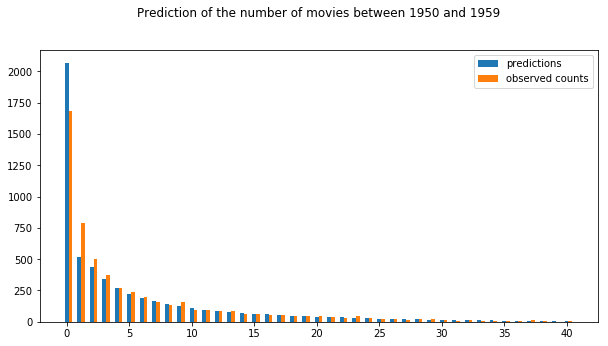

In [30]:
total_training = movie_counts.groupby('primaryName').agg({'numberMovies':'sum'}).merge(actors_list, on = "primaryName", how = "right").fillna(0).groupby("numberMovies").agg({"numberMovies":'count'}).rename(columns = {"numberMovies":"count"}).reset_index()
total_training = total_training.merge(pd.DataFrame({"numberMovies":np.arange(41)}), how = "right").fillna(0).sort_values(by = "numberMovies")

t = 10
width = 0.3
fig, ax = plt.subplots(figsize=(10, 5))
x_list = np.arange(41)
prediction_list = np.array([compute_prediction(n,t) for n in x_list])
ax.bar(x_list, prediction_list, width, label = "predictions")
ax.set_title("Prediction of the number of movies between 1950 and 1959", y = 1.1)

ax.bar(x_list + width, total_training["count"], width, label = "observed counts")

ax.legend(loc = "upper right")

Looking at the plot above, we can see that on the train data, the Poisson process is very well calibrated. For most number of movies, the prediction is correct. There is only a slight overestimation of the number of actors that did 0 movies, combined to an underestimation of the number of actors that did 1 movie.

To assess the goodness of fit on the train period, we can use regression metrics like Mean Squared Error, Mean Absolute Error or the R2 score to measure the difference between these aggregated counts:

In [31]:
mse = mean_squared_error(total_training["count"], prediction_list)
mae = mean_absolute_error(total_training["count"], prediction_list)
r2 = r2_score(total_training["count"], prediction_list)

print("Fit on the train period: \n")
print("- Mean Squared Error: %i" %mse)
print("- Mean Absolute Error: %.1f" %mae)
print("- R2: %.2f" %r2)

Fit on the train period: 

- Mean Squared Error: 5619
- Mean Absolute Error: 22.8
- R2: 0.93


Thus, the model we chose turns out to fit the train period quite well. 

However, when looking at the test period (the next decade), it is a totally different story, as our model grossly overestimates the number of movies made between 1960 and 1969.

In [32]:
t = 10

real_amount = np.sum(movie_counts_validation["numberMovies"])
print("Number of movies made between 1960 and 1969 in reality: %i" % real_amount)

total_prediction = np.sum(lambda_actors["lambda"])*t
print("Expected number of movies made between 1960 and 1969 (Poisson model): %i" % total_prediction)

Number of movies made between 1960 and 1969 in reality: 17056
Expected number of movies made between 1960 and 1969 (Poisson model): 33648


What happened? Why are we suddenly overestimating by 95% the expected number of movies? 

The answer to this question is actually simple: the Poisson process assumes that actors will keep making movies at the same rate... forever. Remember, what we called "active actors" are actors that made at least a movie in 1945-1949. We learned their rate $\lambda_a$ during 1950-1959. It is highly doubtful they would still be making movies at this rate in 1960-1969, or even just highly unlikely they would still all be active by then...

Let us have a closer look at the calibration of the model for the test period:

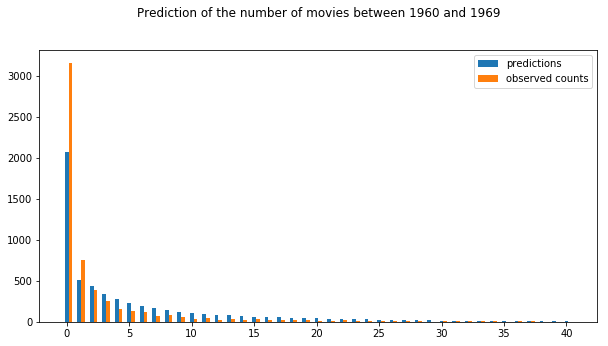

In [33]:
total_validation = movie_counts_validation.groupby('primaryName').agg({'numberMovies':'sum'}).merge(actors_list, on = "primaryName", how = "right").fillna(0).groupby("numberMovies").agg({"numberMovies":'count'}).rename(columns = {"numberMovies":"count"}).reset_index()
total_validation = total_validation.merge(pd.DataFrame({"numberMovies":np.arange(41)}), how = "right").fillna(0).sort_values(by = "numberMovies")

width = 0.3
fig, ax = plt.subplots(figsize=(10, 5))
x_list = np.arange(41)
prediction_list = np.array([compute_prediction(n,t) for n in x_list])
ax.bar(x_list, prediction_list, width, label = "predictions")
ax.set_title("Prediction of the number of movies between 1960 and 1969", y = 1.1)

ax.bar(x_list + width, total_validation["count"], width, label = "observed counts")

ax.legend(loc = "upper right")

This plot confirms what we started explaining above: more than 3000 actors made no movies at all in 1960-1969, although this only happened to less than 2000 in 1950-1959. However, this change is not captured by the Poisson process, that still predicts the same values for this decade than the previous one. 

As a result, all the fit metrics are much worse on the test period than on the train period:

In [34]:
mse = mean_squared_error(total_validation["count"], prediction_list)
mae = mean_absolute_error(total_validation["count"], prediction_list)
r2 = r2_score(total_validation["count"], prediction_list)

print("Fit on the test period: \n")
print("- Mean Squared Error: %i" %mse)
print("- Mean Absolute Error: %.1f" %mae)
print("- R2: %.2f" %r2)

Fit on the test period: 

- Mean Squared Error: 32044
- Mean Absolute Error: 64.0
- R2: 0.87


From this evaluation, it is clear that the Poisson process we suggested as a first approach is way too simplistic because it wrongly assumes that actors remain active forever, which leads to systematic activity overestimation. Moreover, this overestimation can only get worse with time: had we looked at 1970-1979 as a test period, it would obviously have been even more problematic.

As a result, we need to correct this model by adding a dynamic component to it that would capture decrease in activity over time, which would better reflect reality.

## 5. Fitting a Pareto/NBD model

### Model Specification

A good alternative to the Poisson process is provided to us by marketing literature, as you can draw analogies between our setting and common marketing problems. "How many movies do actors make?" can turn into "How many deals does this customer make with my company?", and "Which actor is still active?" can translate as "How many of my customers are still active?" These questions were fundamental in the elaboration of the Pareto/NBD model, presented by Schmittlein et al in "Counting your customers: who are they and what will they do next?" (1987).

The Pareto/NBD model builds on the Poisson process to add a second latent dimension: whether at time $t$, the actor is still active. That way, we do solve for the missing part observed previously, as we now allow actors to be active for a limited amount of time. In the Pareto/NBD model, we follow a two steps approach. First, is the actor still active? If yes, then we can apply the Poisson process as before. This model makes sense from an intuitive point of view, but estimating at what time an actor stops being active is difficult, as we do not observe at what point an actor effectively stops being active (unless death occurs).

Mathematically speaking, this is how we formulate the setting (skip this section if you are not so keen on stats overloads):

- An actor's "lifetime" is modeled with an exponential distribution of "death rate" $\mu_a$ 
- Conditionally on being active, the actor still follows the Poisson process of rate $\lambda_a$

One of the main statistical differences between this model and the Poisson process is that we now place ourselves in the Bayesian framework and assume that all $\mu_a$ and $\lambda_a$ parameters also follow prior distributions:

- The "death rates" $\mu_a$ follow a Gamma distribution of parameters $(s,\beta)$
- The activity rates $\lambda_a$ follow a Gamma distribution of parameters $(r,\alpha)$
- For each actor, we assume $\mu_a$ and $\lambda_a$ to be independent. 

The Exponential-Gamma model for $\mu_a$ results in a Pareto distribution and the Poisson-Gamma model for $\lambda_a$ in a Negative Binomial distribution, hence the name Pareto/NBD. We will not fully write out the formulas of the model here as they quickly get long, however, they are all detailed in Schmittlein et al's paper.

In this setting, an actor's behavior is defined by $(\mu_a,\lambda_a)$, which are functions of each actor's data and prior parameters $(s,\beta,r,\alpha)$. Hence, we actually fully characterize our model with only 4 parameters. The main advantage of the Bayesian approach in this context is that the modeling for each actor will be impacted by the behavior of other actors. For instance, it allows us to learn from the whole panel at what rate an actor typically becomes inactive. This is critical: how else could we predict that an actor who was very active in 1950-1959 could then suddenly stop making movies somewhere in the 1960's?

### Training the model using the "lifetimes" package

Fortunately, the "lifetimes" package spares us the parameter estimation for this problem, which otherwise would be quite tedious. To use the package, we need to convert our data to a dataframe with 3 attributes per actor:

- frequency: number of movies in 1950-1959 (train period)
- recency: the year of the last movie
- T: the number of years in the train period (10 in our case)

To comply with the package's notation, the year last year of the train period - 1949 - represents now year 0. This is what we eventually get:

In [57]:
movie_counts_reshape = movie_counts.groupby("primaryName").agg({"numberMovies":'sum', "startYear":'max'}).reset_index().rename(columns = {"startYear":"recency","numberMovies":"frequency"})
movie_counts_reshape = movie_counts_reshape.merge(actors_list, on = "primaryName", how = "right")
movie_counts_reshape["recency"] = movie_counts_reshape.recency - startYear + 1
movie_counts_reshape.fillna(0, inplace = True)
movie_counts_reshape["T"] = endYear-startYear
movie_counts_reshape[movie_counts_reshape.primaryName.isin(actors)]

,primaryName,frequency,recency,T
397,Bette Davis,9.0,10.0,10
549,Cary Grant,13.0,10.0,10
636,Clark Gable,14.0,10.0,10
922,Elizabeth Taylor,15.0,10.0,10
1462,Henry Fonda,9.0,10.0,10
1586,Ingrid Bergman,10.0,9.0,10
1681,James Stewart,22.0,10.0,10
2047,Katharine Hepburn,7.0,10.0,10


With this dataframe in hand, all we need to do is to pass it to the ParetoNBDFitter.

In [36]:
pnbd = ParetoNBDFitter(penalizer_coef=0.1)
pnbd.fit(movie_counts_reshape['frequency'], movie_counts_reshape['recency'], movie_counts_reshape['T'])

<lifetimes.ParetoNBDFitter: fitted with 5668 subjects, alpha: 0.77, beta: 36.96, r: 0.52, s: 1.17>

In [37]:
print("Parameter estimation of the Pareto/NBD model: \n")
print(pnbd.params_)

Parameter estimation of the Pareto/NBD model: 

r         0.516506
alpha     0.772348
s         1.166799
beta     36.958876
dtype: float64


### Model Interpretation

Let us first have a look at the four parameters estimated above: $(r, \alpha, s, \beta)$. These parameters allow us to specify the two gamma distributions (priors) from which all the $\lambda_a$ and $\mu_a$ values are drawn.

Text(0.5, 1.0, 'Probability distribution of the \n mu parameters')

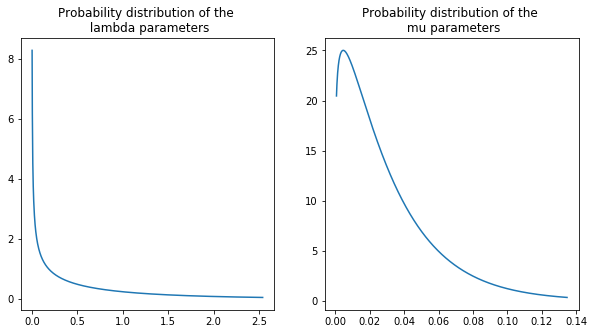

In [38]:
lambda_x_list = x = np.linspace(gamma.ppf(0.05, a = pnbd.params_['r'], scale = 1/pnbd.params_['alpha']), 
                                gamma.ppf(0.95, a = pnbd.params_['r'], scale = 1/pnbd.params_['alpha']), 1000)
mu_x_list = x = np.linspace(gamma.ppf(0.01, a = pnbd.params_['s'], scale = 1/pnbd.params_['beta']), 
                                gamma.ppf(0.99, a = pnbd.params_['s'], scale = 1/pnbd.params_['beta']), 1000)
lambda_y_list = gamma.pdf(lambda_x_list, a = pnbd.params_['r'], scale = 1/pnbd.params_['alpha'])
mu_y_list = gamma.pdf(mu_x_list, a = pnbd.params_['s'], scale = 1/pnbd.params_['beta'])

fig, axes = plt.subplots(1,2, figsize = (10,5))
axes[0].plot(lambda_x_list, lambda_y_list)
axes[0].set_title("Probability distribution of the \n lambda parameters")
axes[1].plot(mu_x_list, mu_y_list)
axes[1].set_title("Probability distribution of the \n mu parameters")

In [39]:
mean_lambda_a = pnbd.params_['r']/pnbd.params_['alpha']
mean_mu_a = pnbd.params_['s']/pnbd.params_['beta']
print("Among all actors, the mean 'activity rate' lambda_a is: %.2f" % mean_lambda_a)
print("Among all actors, the mean 'death rate' mu_a is: %.2f" % mean_mu_a)

Among all actors, the mean 'activity rate' lambda_a is: 0.67
Among all actors, the mean 'death rate' mu_a is: 0.03


As you can tell from these two distribution plots, the $\mu_a$ parameters are very concentrated around the mode at $0.01$. The $\lambda_a$ parameters, on the other hand, are drawn from a gamma distribution that allows a wider range of values. In other words, the Pareto/NBD model suggests that while actors might differ a lot in terms of movie frequency, they are very similar in the way they end their career. 

The very different shapes of the two distribution plots illustrate why the Gamma distribution is such a popular choice for priors in Bayesian analysis, as it allows to fit very data sets of very different shapes.

Let us now have a closer look at the probability to be active, which is the key feature of the Pareto/NBD model compared to the more naive Poisson model. The implications of this model is that the longer it has been since an actor made his or her last movie, the more likely it is that the actor now is inactive.

In [0]:
t_future = 10

def plot_p_alive_actor(ax, actor_name):
  history_actor = movie_counts[movie_counts.primaryName == actor_name]
  history_actor.startYear = pd.to_datetime(history_actor.startYear, format='%Y')
  plot_history_alive(pnbd, t_future, history_actor, 'startYear', freq = 'Y', ax = ax)
  ax.set_title(actor_name)
  ax.legend(loc = 'lower left', labels = ['P_alive','movies'])

def plot_p_alive_actors(actors):
  n = len(actors)
  k = round(n/3+0.5)
  fig, axes = plt.subplots(k,3, figsize = (15,2*k))
  for ax, actor_name in zip(axes.ravel(), actors):
    plt.sca(ax)
    plot_p_alive_actor(ax, actor_name)
  for i in range(n,k*3):
    fig.delaxes(axes.ravel()[i])
  fig.suptitle("Probability of being active during the training period", y = 1.1, fontsize = 20)
  fig.tight_layout()

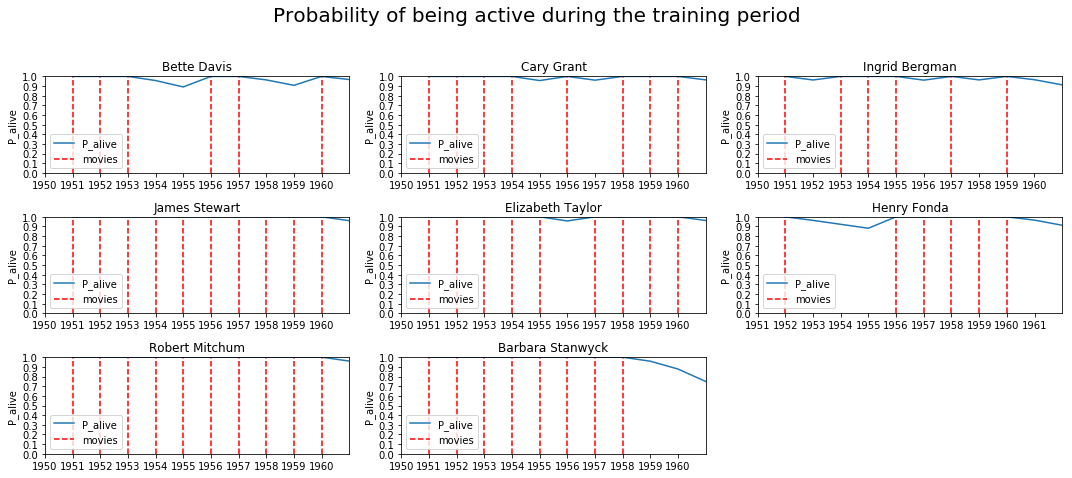

In [79]:
plot_p_alive_actors(actors)

In the Pareto/NBD model, an actor's probability to be still active is mainly driven by the recency of the last movie. However, it is also connected to the actor's frequency. This twofold dependency can be visualized in the heatmap below. For instance, observing the last movie in the train period was in 1957 (year 8 in the model) will not mean that much if the actor used to make very little movies before that and that we observed several such gaps before. On the other hand, if an actor used to make a lot of movies in the past but suddenly stopped in 1957, it is much more likely that this is because it stopped active. This explains the characteristic shape of the heatmap.

Text(0, 0.5, "Actor's Recency")

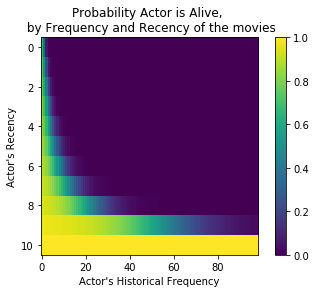

In [42]:
plot_probability_alive_matrix(pnbd)
plt.title("Probability Actor is Alive, \n by Frequency and Recency of the movies")
plt.xlabel("Actor's Historical Frequency")
plt.ylabel("Actor's Recency")

As a result, the Pareto/NBD model assumes that the more movies an actor has made in the train period and the more recent the last movie was, the more movies this actor is likely to make in the next period. The heatmap below illustrates this double dependency and has the same characteristic shape as previously.

Text(0, 0.5, "Actor's Recency")

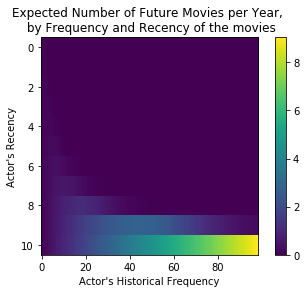

In [43]:
plot_frequency_recency_matrix(pnbd)
plt.title("Expected Number of Future Movies per Year, \n by Frequency and Recency of the movies")
plt.xlabel("Actor's Historical Frequency")
plt.ylabel("Actor's Recency")

In [80]:
t_future = 10
movie_counts_reshape['predicted_purchases'] = pnbd.conditional_expected_number_of_purchases_up_to_time(t_future, movie_counts_reshape['frequency'], movie_counts_reshape['recency'], movie_counts_reshape['T'])

movie_counts_reshape[movie_counts_reshape.primaryName.isin(actors)]

,primaryName,frequency,recency,T,predicted_purchases
350,Barbara Stanwyck,22.0,8.0,10,8.879765
397,Bette Davis,9.0,10.0,10,7.881290
549,Cary Grant,13.0,10.0,10,11.193972
922,Elizabeth Taylor,15.0,10.0,10,12.850313
1462,Henry Fonda,9.0,10.0,10,7.881290
1586,Ingrid Bergman,10.0,9.0,10,8.341245
1681,James Stewart,22.0,10.0,10,18.647506
3244,Robert Mitchum,25.0,10.0,10,21.132018


In [0]:
predictions = movie_counts_reshape[movie_counts_reshape.primaryName.isin(actors)][["primaryName","frequency","predicted_purchases"]]
real_number = movie_counts_validation[movie_counts_validation.primaryName.isin(actors)].groupby('primaryName').agg({'numberMovies':'sum'})
predictions_actors = predictions.merge(real_number, on = "primaryName")

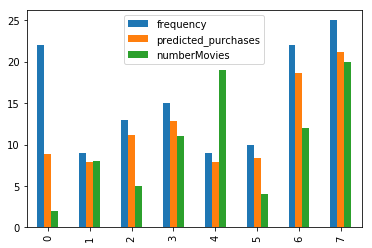

In [87]:
predictions_actors.plot.bar()

In [62]:
movie_counts_validation[movie_counts_validation.primaryName.isin(actors)].groupby('primaryName').agg({'numberMovies':'sum'})

,numberMovies
primaryName,
Bette Davis,8
Cary Grant,5
Clark Gable,2
Elizabeth Taylor,11
Henry Fonda,19
Ingrid Bergman,4
James Stewart,12
Katharine Hepburn,4


In [48]:
pnbd.conditional_probability_of_n_purchases_up_to_time(0, t_future, movie_counts_reshape['frequency'], movie_counts_reshape['recency'], movie_counts_reshape['T'])[:5]

0    0.255259
1    0.036017
2    0.830928
3    0.069457
4    0.007229
dtype: float64

### Model Evaluation

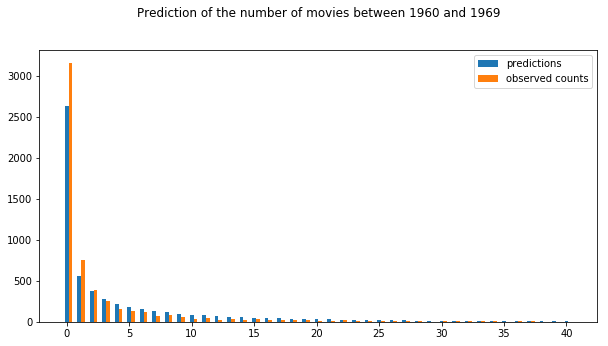

In [49]:
width = 0.3
fig, ax = plt.subplots(figsize=(10, 5))
x_list = np.arange(41)
prediction_list = np.array([pnbd.conditional_probability_of_n_purchases_up_to_time(n, t_future, movie_counts_reshape['frequency'], 
                                                     movie_counts_reshape['recency'], movie_counts_reshape['T']).sum() for n in x_list])
ax.bar(x_list, prediction_list, width, label = "predictions")
ax.set_title("Prediction of the number of movies between 1960 and 1969", y = 1.1)

ax.bar(x_list + width, total_validation["count"], width, label = "observed counts")

ax.legend(loc = "upper right")

In [50]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
mean_squared_error(total_validation["count"], prediction_list),mean_absolute_error(total_validation["count"], prediction_list),r2_score(total_validation["count"], prediction_list)

(8118.8665304726255, 35.525689795607455, 0.9668683382370756)

## 6. Conclusion